<a href="https://colab.research.google.com/github/Homabeyrami/ML_Project_Pra/blob/main/KC_4_V6H__XGB_modified_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle API and Data Download




## Install LIB



In [1]:
!pip install optuna
!pip install shap
!pip install yellowbrick
# Install XGBoost (if not already installed)
!pip install xgboost
# Install SHAP (if not already installed)
!pip install shap



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.5 MB/s eta 0:00:00


<a id = "1"></a><br>
# Load Python Pakages


In [2]:
# Run this cell to download and extract data
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e7:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73291%2F8930475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240709%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240709T060028Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2624b1110f8bfc94752342c2ce07fdc5719dd07abd9a4c95934ae25a92674de4ddd2ef2ef90c707a5facab1fbf765df450adcd6e00eedc0de31b2b51dbb841f2a9b300875653097440868f21db1d1c55e8cd28564fc7e8a774efc9a6e4c6e530856d23a0d3e979c8e2fcf7fab1e3aa75c43db4a89beb5d9f05ea5bd59489804471c25b071f4bc15a923e16712626103075899c35902c0430844bb06ff702ad430da1c8946f4da04bf016b49c213dff0e842fbb1dae9c977dcaf999d616d38ecafbe36832f080d7a6bdb053c56b13f3ddb99fb9fdcad2eba54baaf2edfa032264a2b75a7eb03251418a2aef0bdf9bcdd7c0edff6f006ce488ffdfa626f99f3e26'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 259402906 bytes downloaded
Downloaded and uncompressed: playground-series-s4e7
Data source import complete.


In [3]:
#basics
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno


import warnings
warnings.filterwarnings("ignore")
import os
#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from xgboost import XGBClassifier
import xgboost as xgb
# Import necessary libraries
import shap
from xgboost import plot_importance


#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

random_state = 42
print("Libraries imported successfully.")
%load_ext cudf.pandas


Libraries imported successfully.


<a id = "2"></a><br>
#  First look to data

In [4]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

# Display first few rows of the datasets
print(train_df.head())
print(test_df.head())


   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female   35                1          1.0                   0   
4   4  Female   36                1         15.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   
2    < 1 Year             No         38043.0                 152.0      254   
3    1-2 Year            Yes          2630.0                 156.0       76   
4    1-2 Year             No         31951.0                 152.0      294   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  
        

In [ ]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [ ]:
print(train_df.shape)
print(test_df.shape)

(11504798, 12)
(7669866, 11)


<a id = "3"></a><br>
## Descpriptive statistics

In [5]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


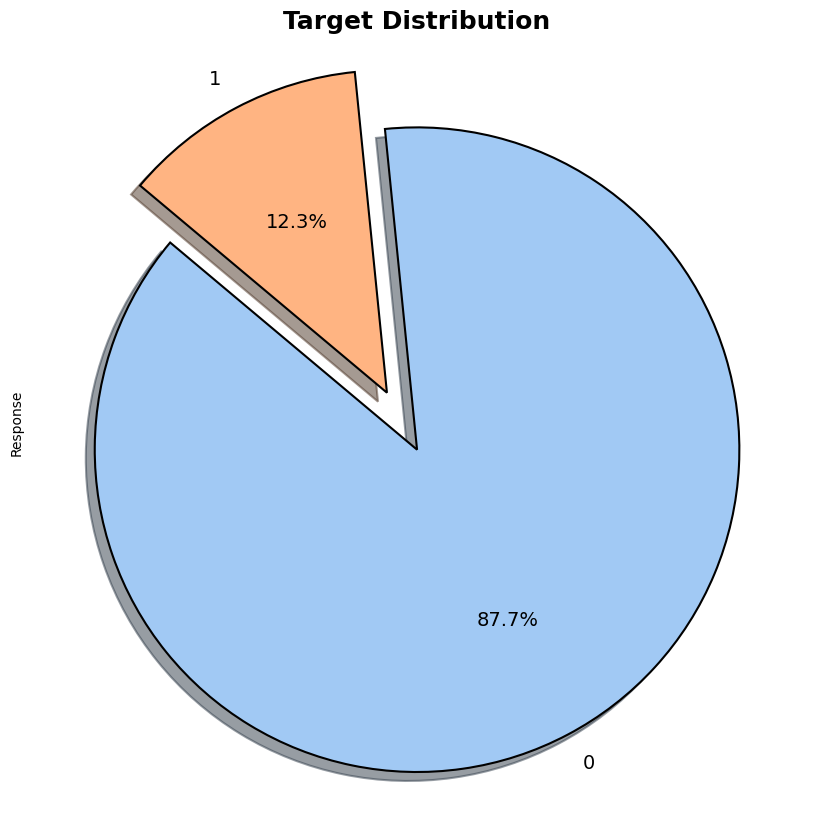

In [6]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.1 for _ in range(train_df['Response'].nunique())]

# Plotting
train_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

## Grouping features for preprocessing purposes

In [ ]:
train_df.nunique().sort_values()

Gender                         2
Driving_License                2
Previously_Insured             2
Vehicle_Damage                 2
Response                       2
Vehicle_Age                    3
Region_Code                   54
Age                           66
Policy_Sales_Channel         152
Vintage                      290
Annual_Premium             51728
id                      11504798
dtype: int64

In [ ]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype
---  ------                -----
 0   id                    int64
 1   Gender                object
 2   Age                   int64
 3   Driving_License       int64
 4   Region_Code           float64
 5   Previously_Insured    int64
 6   Vehicle_Age           object
 7   Vehicle_Damage        object
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64
 11  Response              int64
dtypes: float64(3), int64(6), object(3)
memory usage: 1.1+ GB


In [7]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numerical
label_encoders = {}
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

for feature in categorical_features:
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    label_encoders[feature] = le

# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if feature != "Response"]
target = "Response"

binary_features = ['Previously_Insured', 'Driving_License']
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

continuous_features = list(set(feature_list) - set(binary_features) - set(categorical_features))

assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()



<a id = "4"></a><br>
# Exploratory Data Analysis

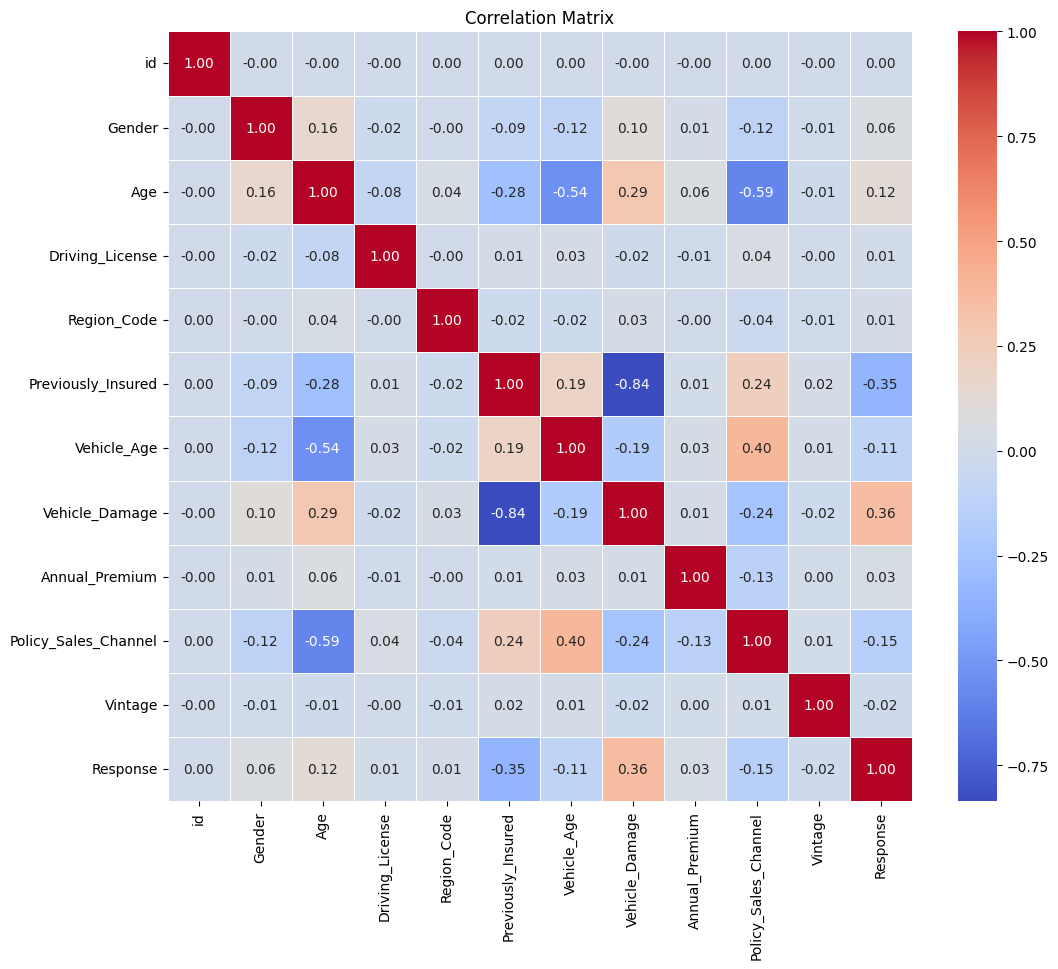

In [ ]:
# Plot heatmap for correlation matrix
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

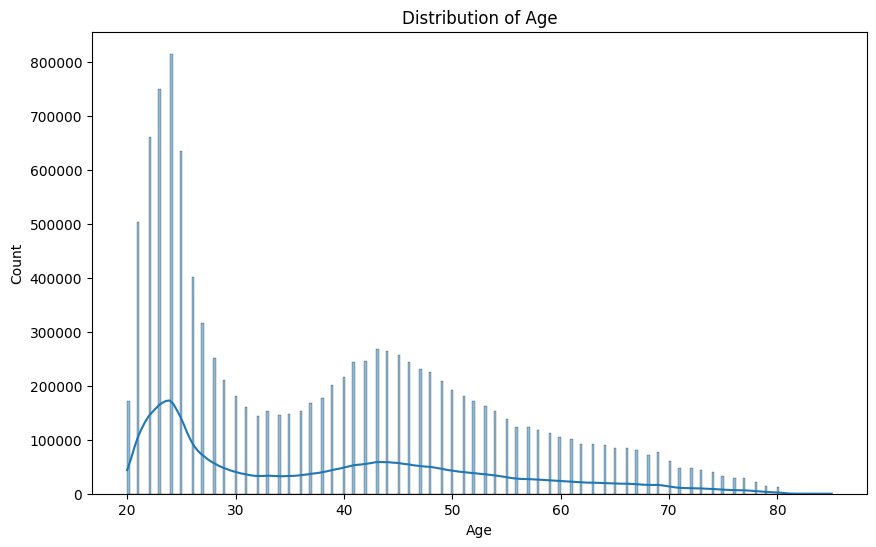

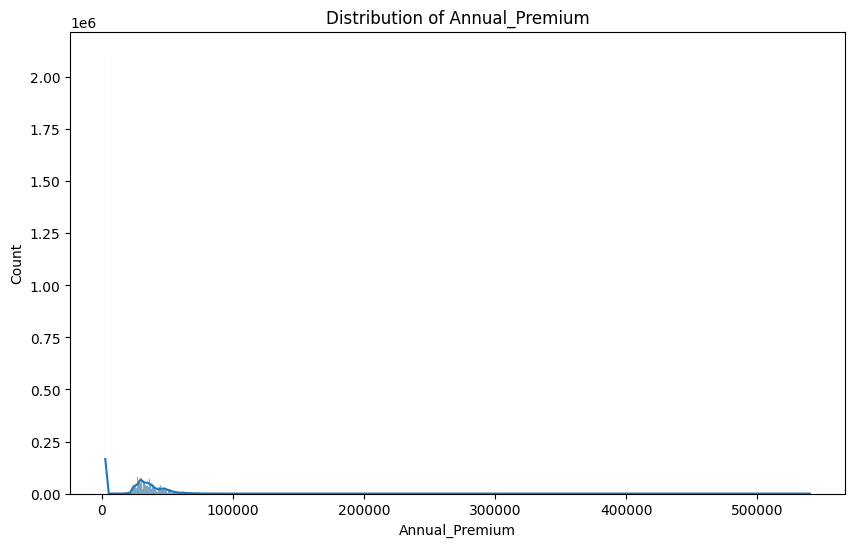

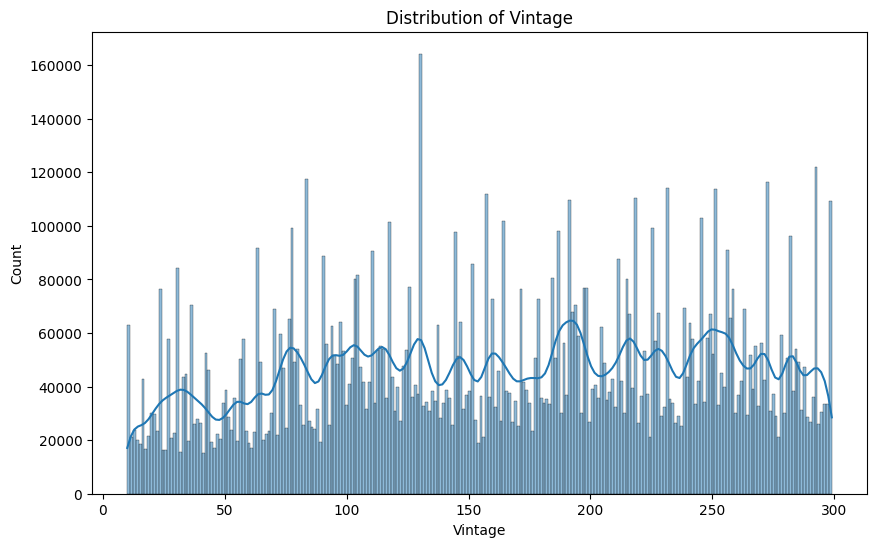

In [ ]:
# Plot distributions of numerical features
numeric_features = ['Age', 'Annual_Premium', 'Vintage']
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


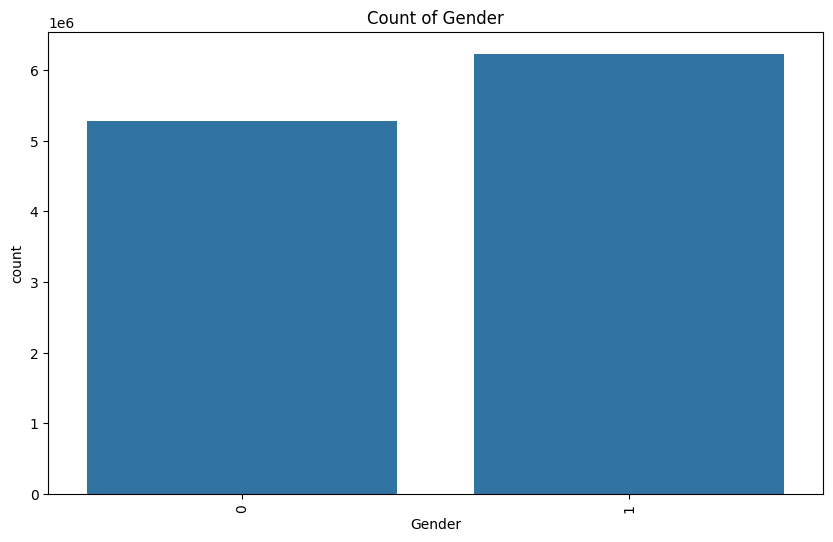

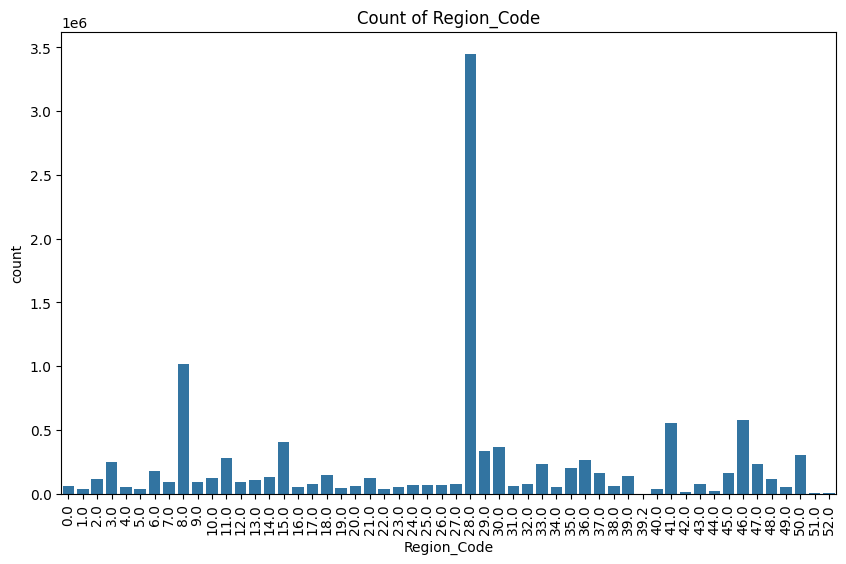

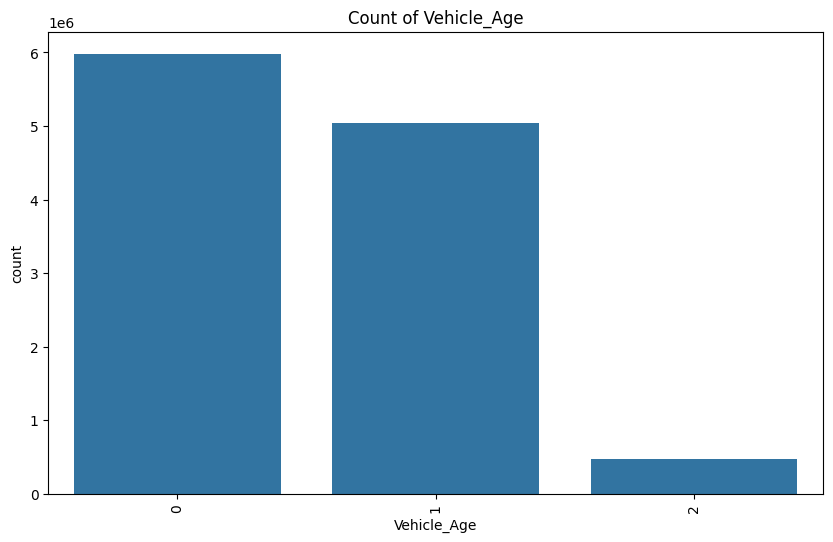

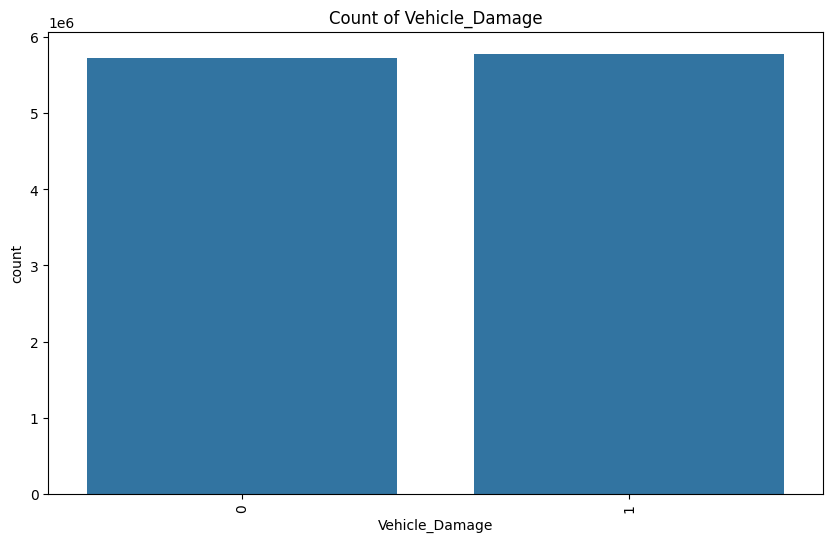

In [ ]:
# Plot categorical features
categorical_features = ['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=train_df)
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=90)  # Rotate x-axis labels to prevent overlapping
    plt.show()

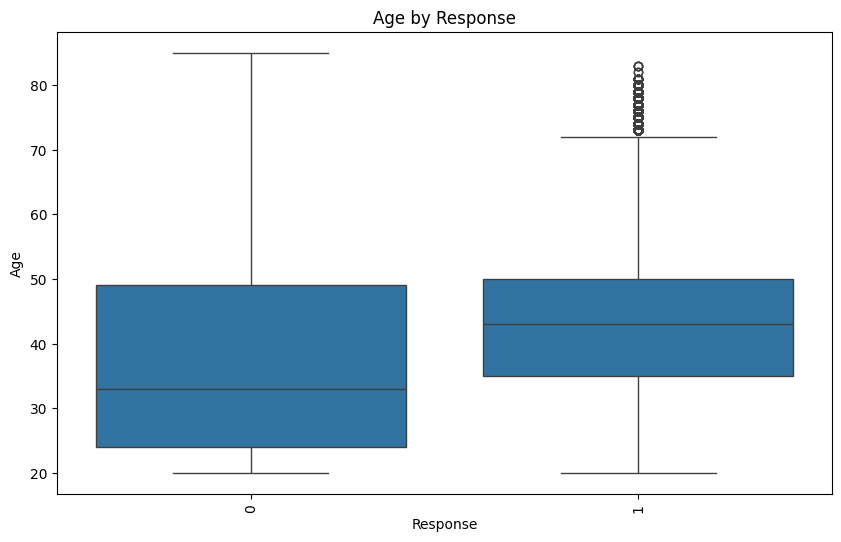

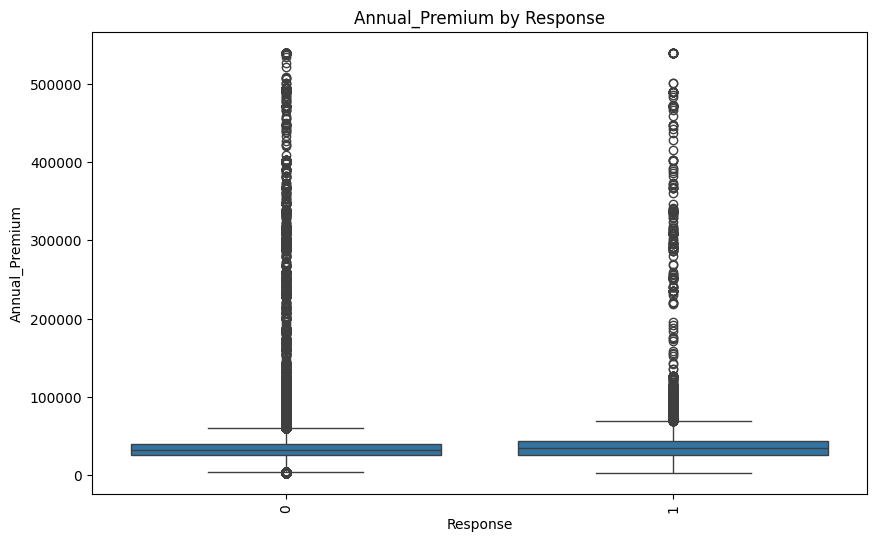

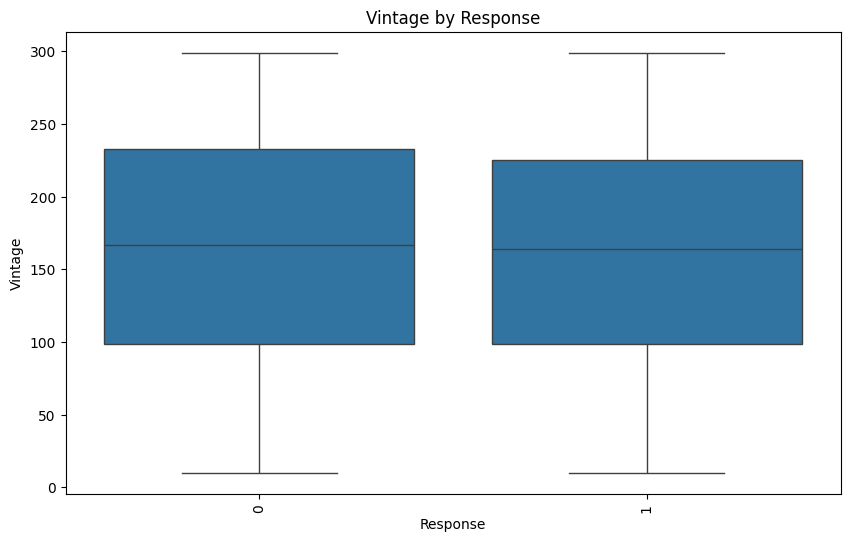

In [ ]:
# Boxplot for numerical features by response
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Response', y=feature, data=train_df)
    plt.title(f'{feature} by Response')
    plt.xticks(rotation=90)  # Rotate x-axis labels to prevent overlapping
    plt.show()

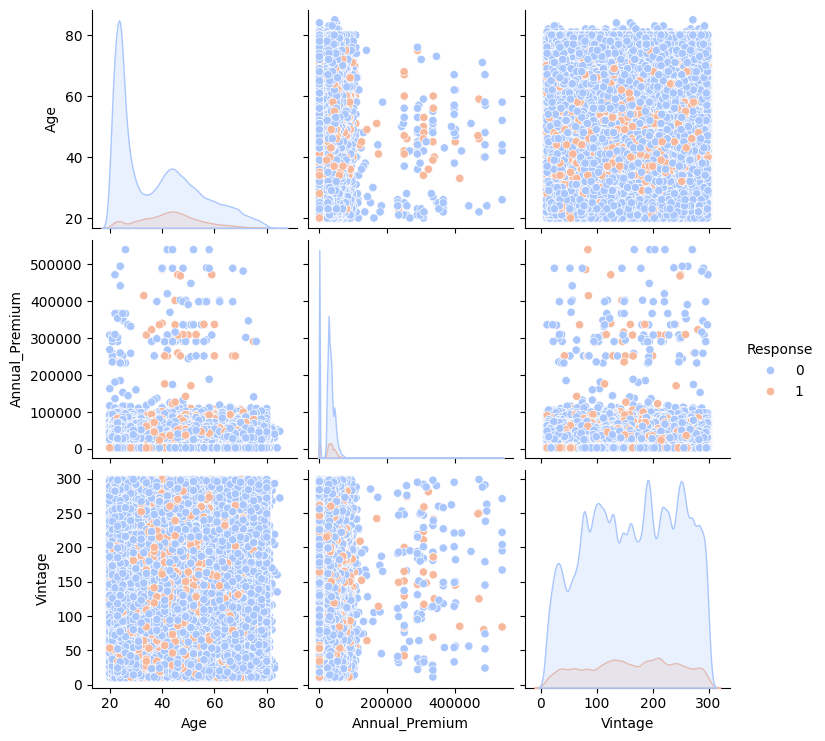

In [ ]:
# Pair plot for important features with sampling to optimize memory and time
subset_features = ['Age', 'Annual_Premium', 'Vintage', 'Response']

# Sample a fraction of the data to reduce memory and time consumption
sampled_df = train_df[subset_features].sample(frac=0.1, random_state=42)  # Adjust the fraction as needed

sns.pairplot(sampled_df, hue='Response', palette='coolwarm')
plt.show()


In [ ]:
'''# Pair plot for important features
subset_features = ['Age', 'Annual_Premium', 'Vintage', 'Response']
sns.pairplot(train_df[subset_features], hue='Response', palette='coolwarm')
plt.show()

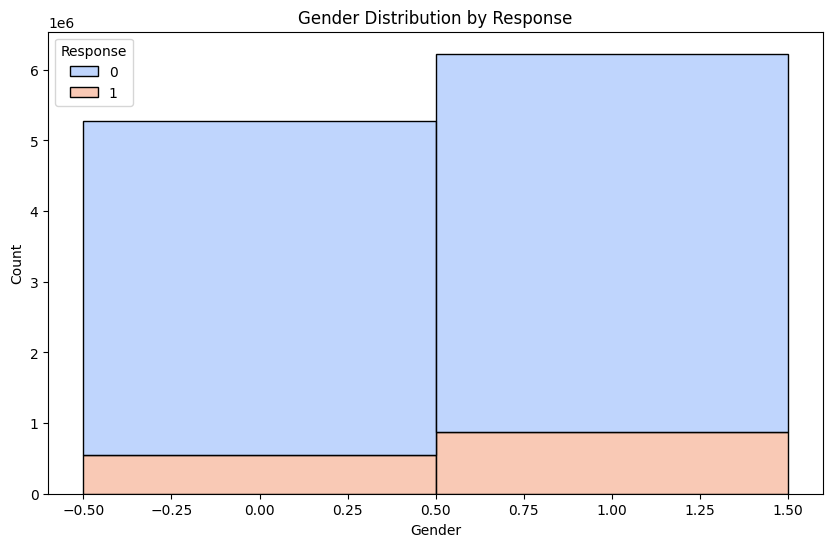

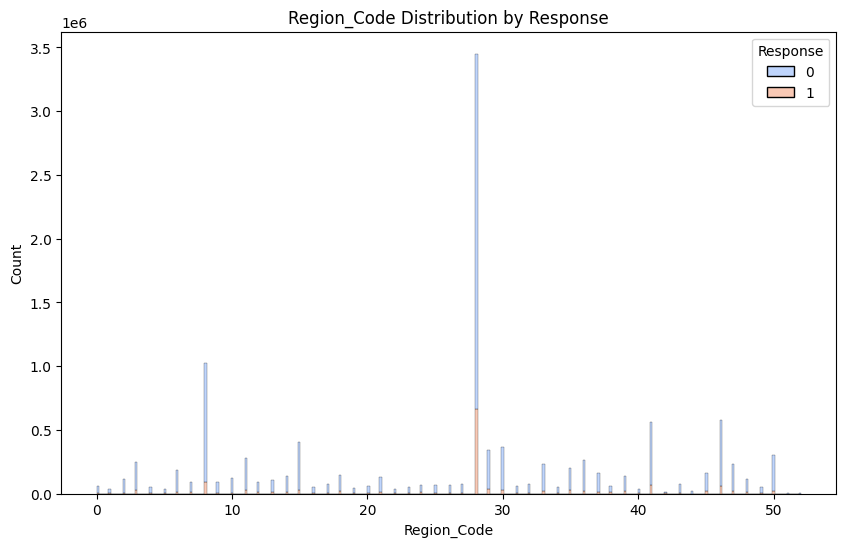

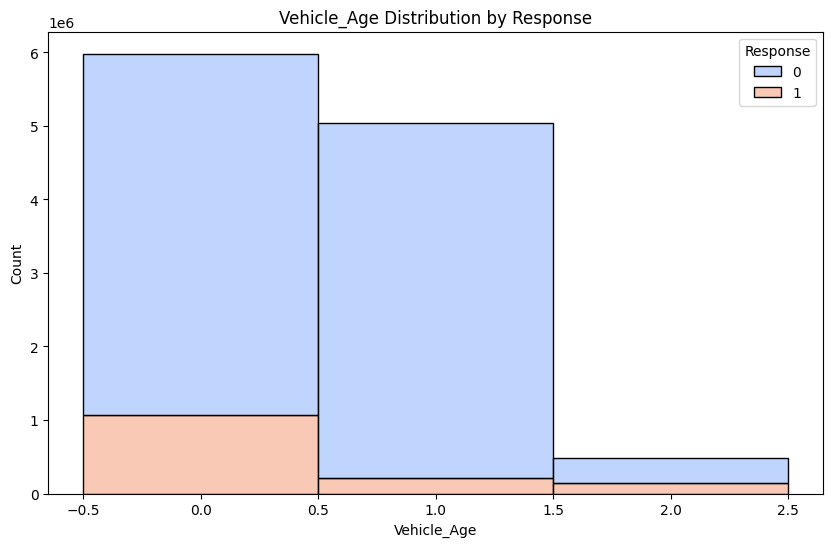

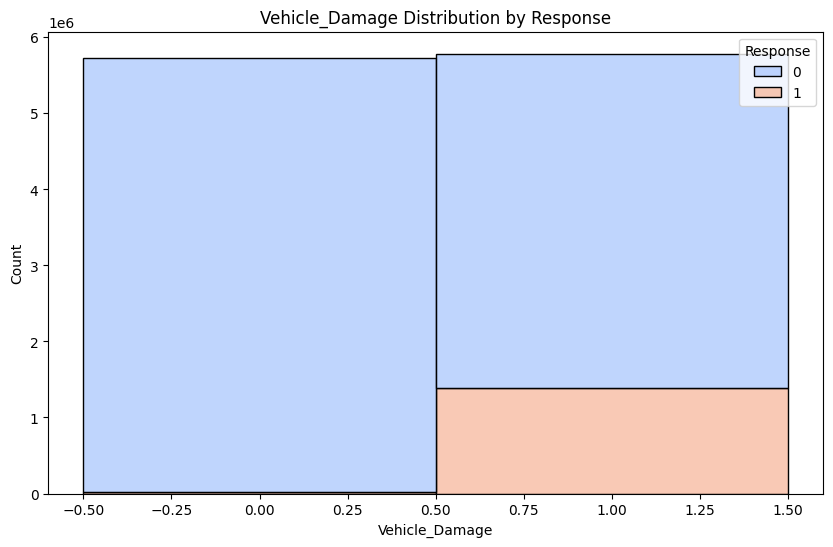

In [ ]:
# Stacked bar plot for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_df, x=feature, hue='Response', multiple='stack', palette='coolwarm')
    plt.title(f'{feature} Distribution by Response')
    plt.show()

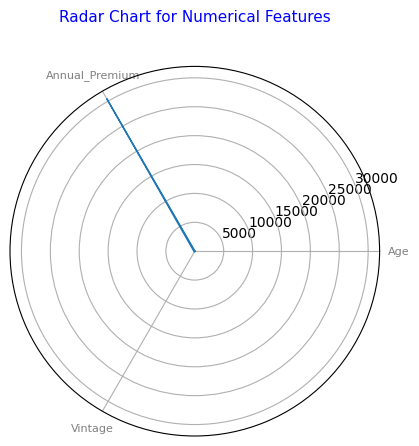

In [ ]:
# Radar chart for numerical features
from math import pi
import matplotlib.pyplot as plt

def create_radar_chart(data, features, title):
    categories = list(features)
    N = len(categories)

    values = data[features].mean().tolist()
    values += values[:1]

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(title, size=11, color='b', y=1.1)
    plt.show()

features = ['Age', 'Annual_Premium', 'Vintage']
create_radar_chart(train_df, features, 'Radar Chart for Numerical Features')


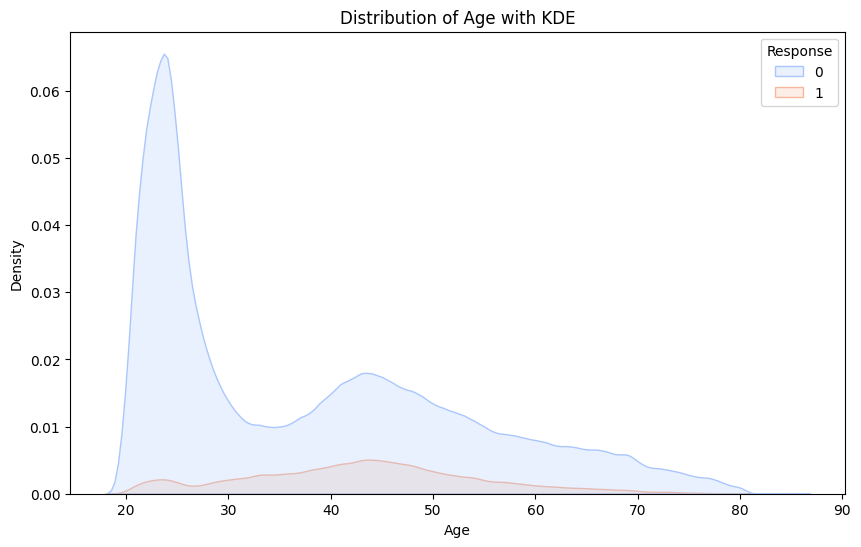

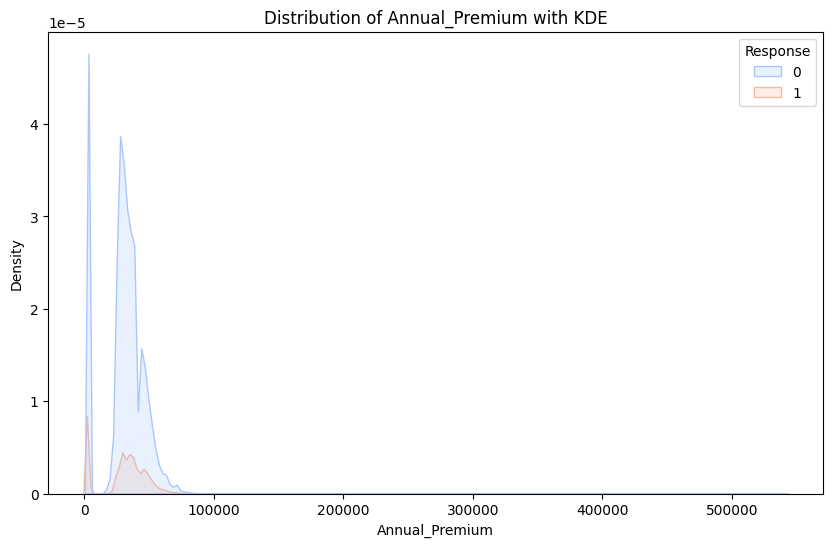

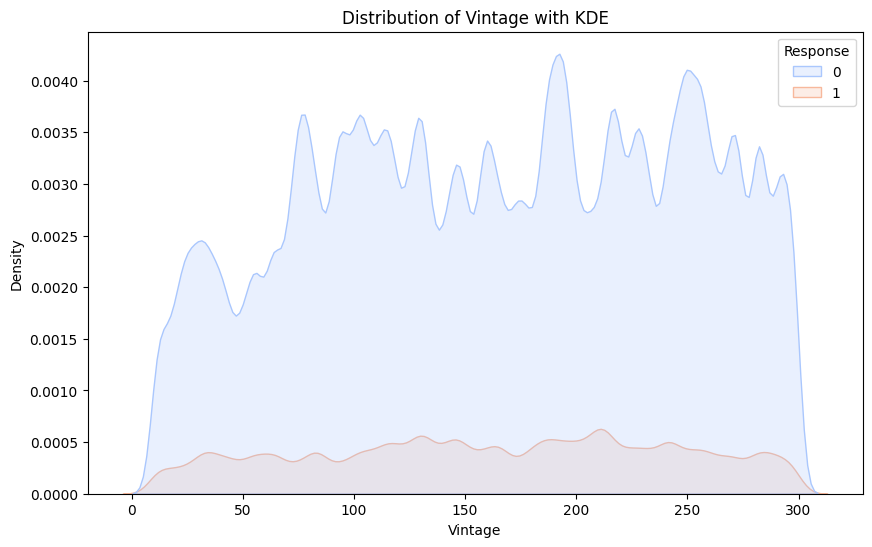

In [ ]:
# Distribution plot with KDE for numerical features
import seaborn as sns

numeric_features = ['Age', 'Annual_Premium', 'Vintage']
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=train_df, x=feature, hue='Response', palette='coolwarm', fill=True)
    plt.title(f'Distribution of {feature} with KDE')
    plt.show()


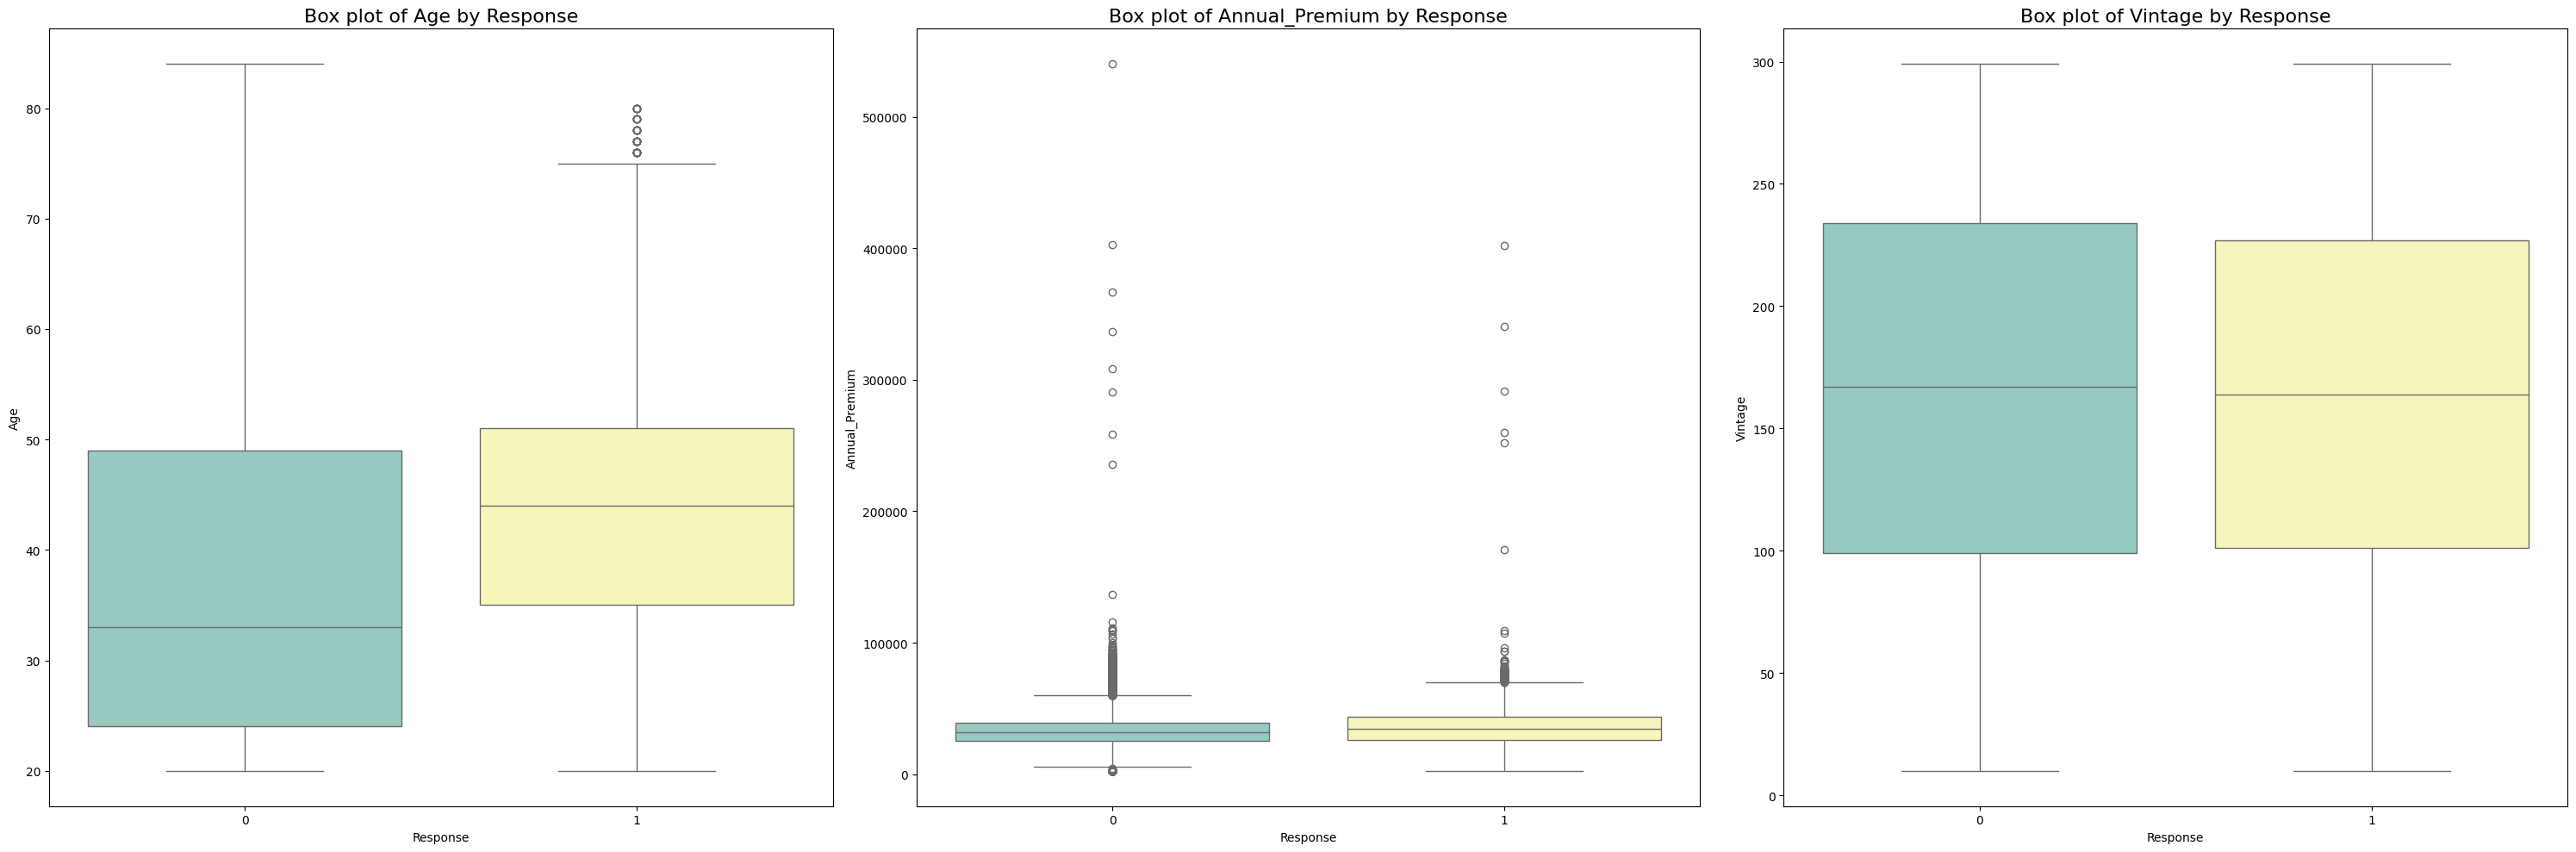

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample 1% of the data for EDA
eda_df = train_df.sample(frac=0.01, random_state=42)

# Box plots for continuous features by Response
continuous_features = ['Age', 'Annual_Premium', 'Vintage']
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Response', y=var, data=eda_df, ax=subplot, palette='Set3')
    subplot.set_title(f'Box plot of {var} by Response', fontsize=16)
plt.tight_layout()
plt.show()


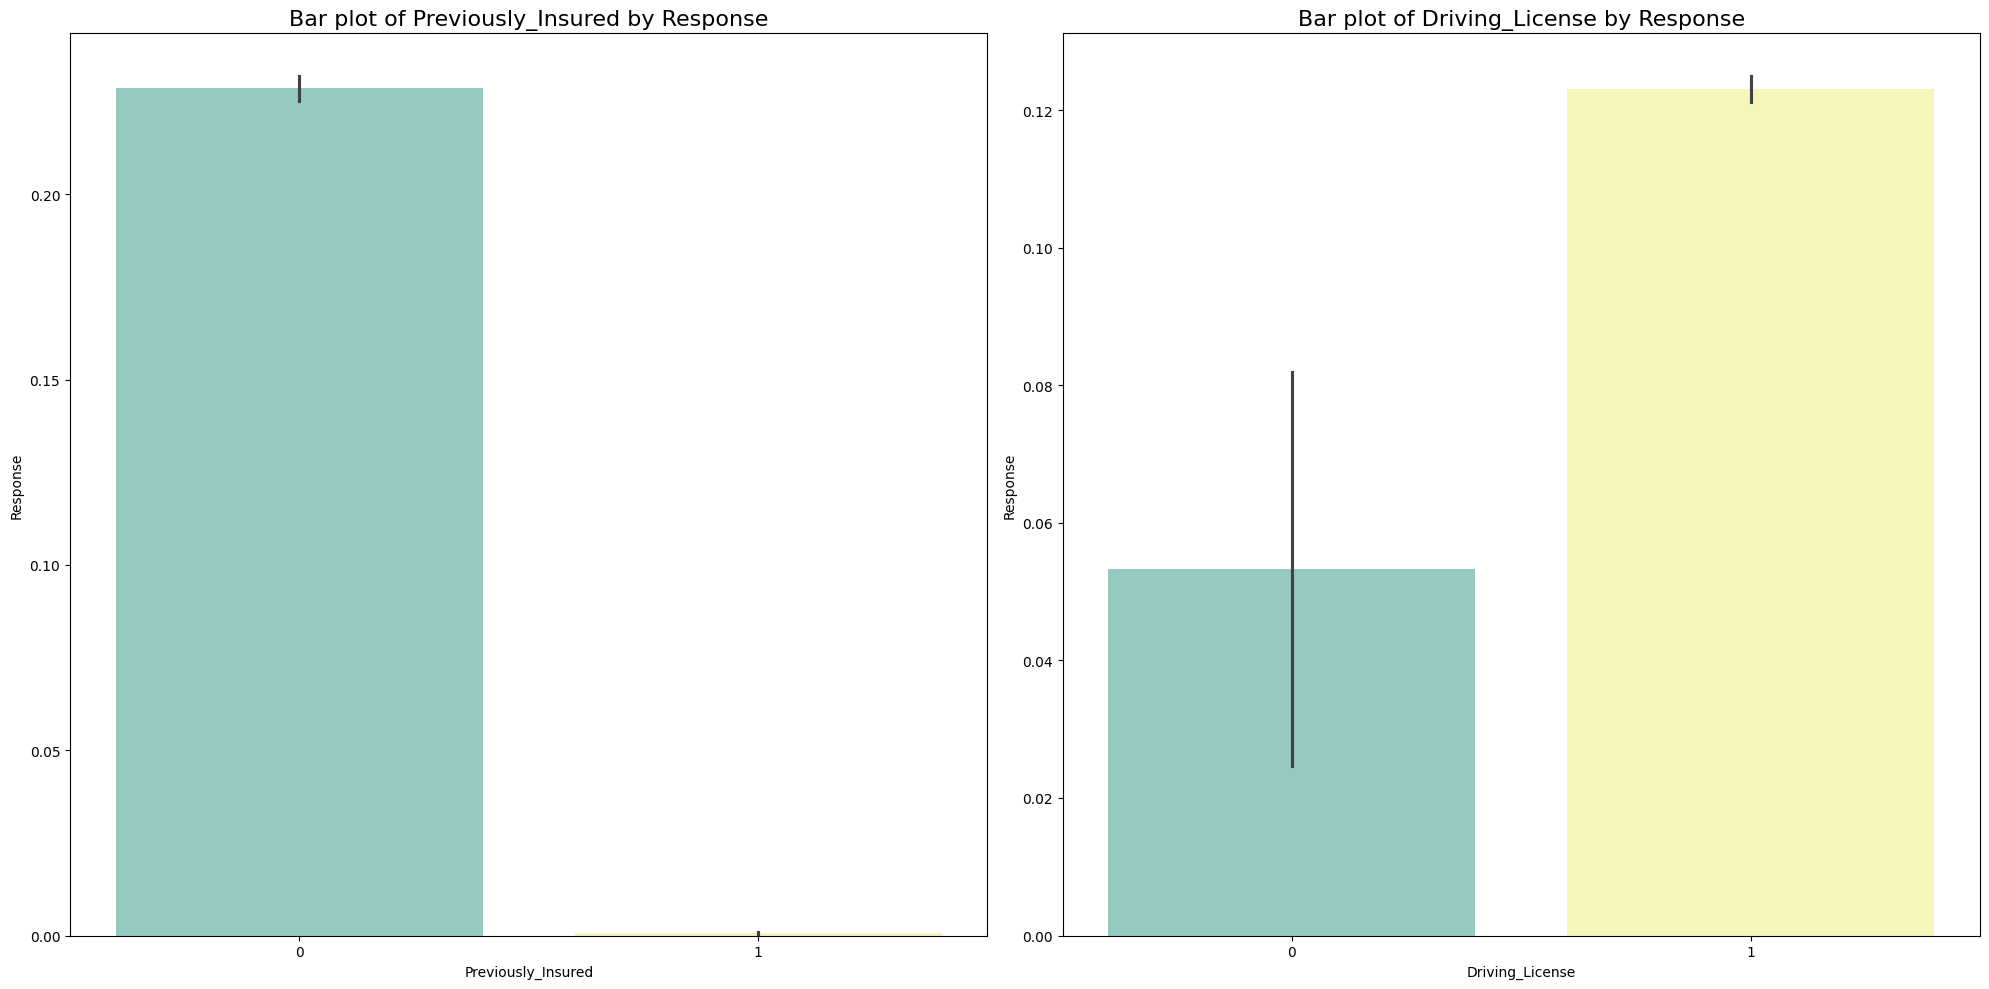

In [ ]:
# Bar plots for binary features by Response
binary_features = ['Previously_Insured', 'Driving_License']
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x=var, y='Response', data=eda_df, ax=subplot, palette='Set3')
    subplot.set_title(f'Bar plot of {var} by Response', fontsize=16)
plt.tight_layout()
plt.show()


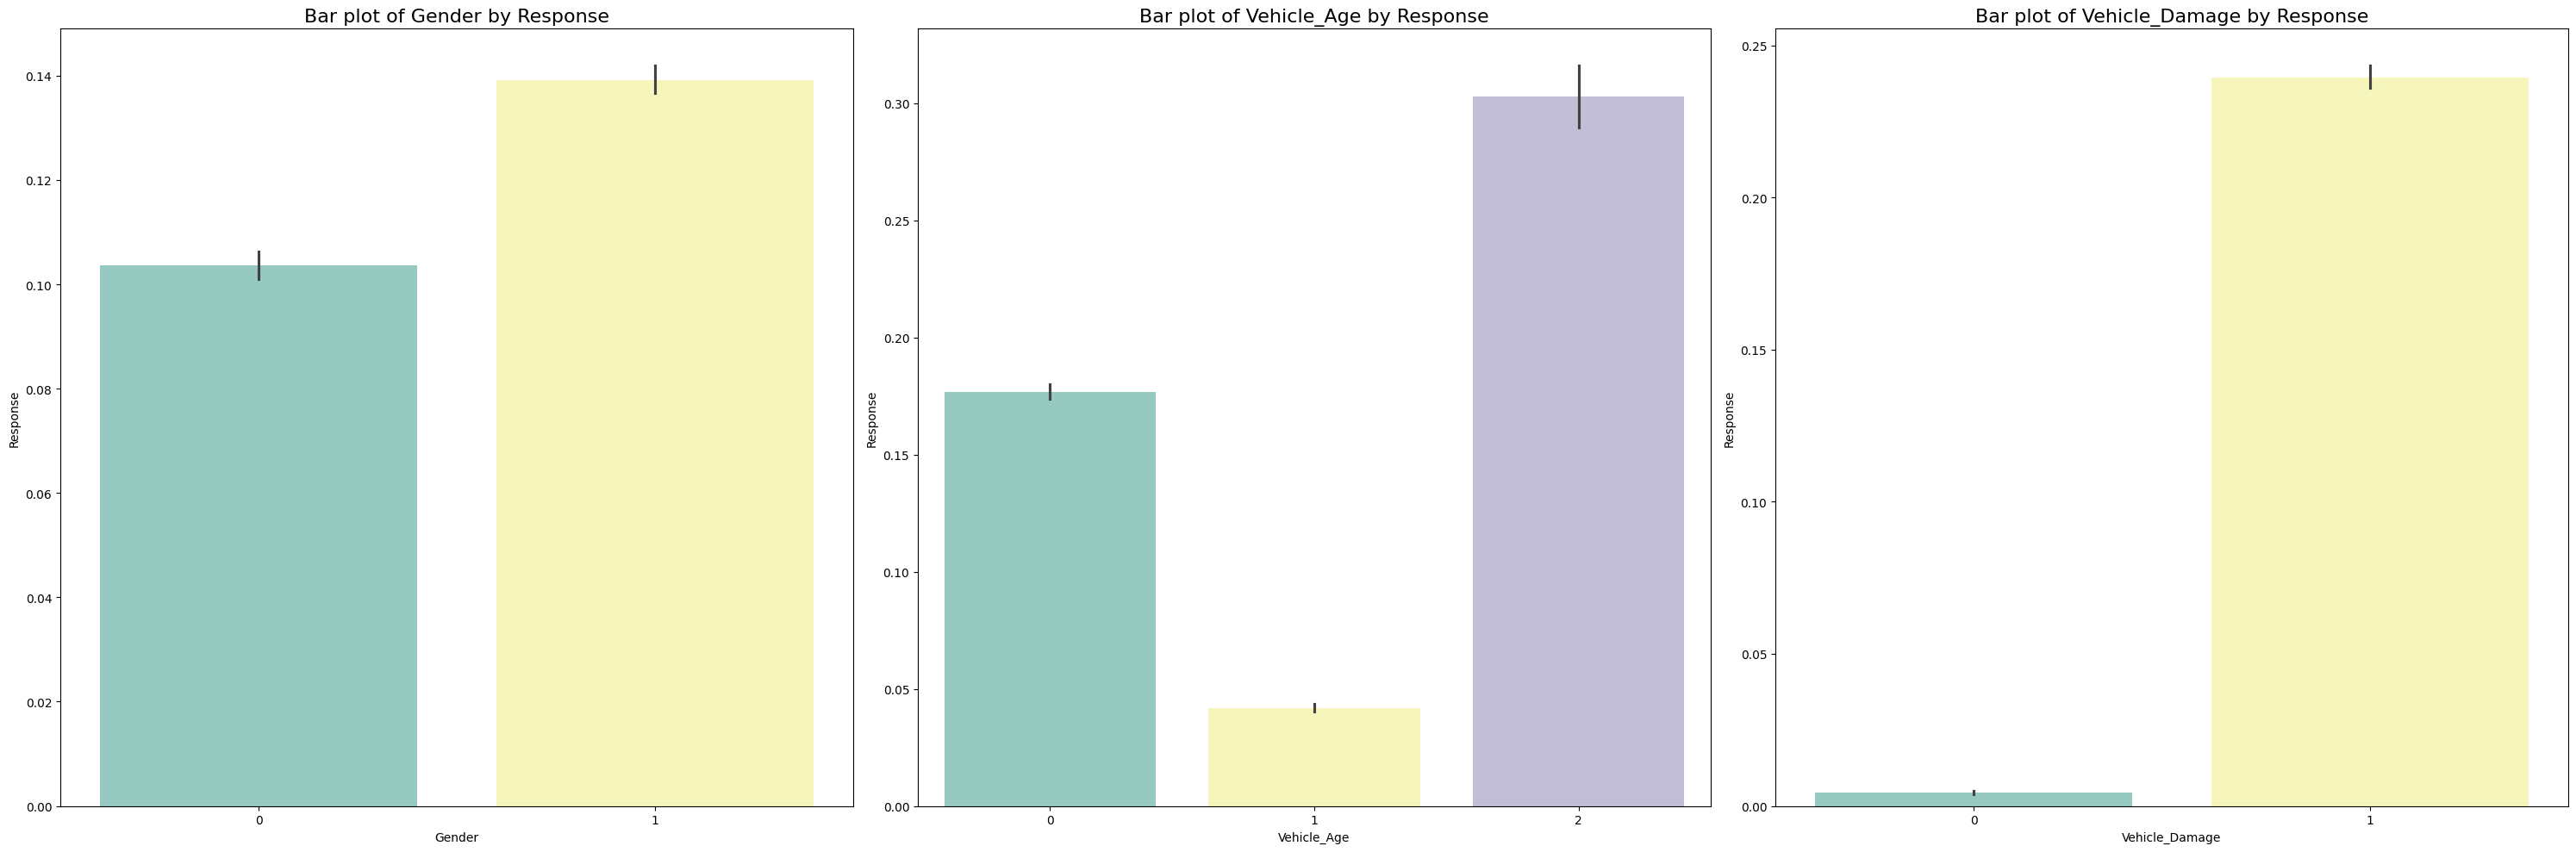

In [ ]:
# Bar plots for categorical features by Response
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.barplot(x=var, y='Response', data=eda_df, ax=subplot, palette='Set3')
    subplot.set_title(f'Bar plot of {var} by Response', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
'''eda_df = train_df.sample(frac= 0.01)

<a id = "5"></a><br>
# Feature Engineering

In [8]:
# Sample 1% of the data for EDA
eda_df = train_df.sample(frac=0.01, random_state=42)

# Define the continuous and binary features
continuous_features = ['Age', 'Annual_Premium', 'Vintage']
binary_features = ['Previously_Insured', 'Driving_License']

# Determine the mutual information for numerical features
mutual_df = eda_df[continuous_features + binary_features]
y_sampled = eda_df['Response']
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=42)

# Create a DataFrame to display the mutual information
mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=["Numerical_Feature_MI"])

# Display the mutual information with a background gradient
mutual_info.style.background_gradient(cmap="cool")


,Numerical_Feature_MI
Previously_Insured,0.097063
Age,0.031280
Annual_Premium,0.022653
Driving_License,0.021342
Vintage,0.014029


In [9]:
# Sample 1% of the data for EDA
eda_df = train_df.sample(frac=0.01, random_state=42)

# Define the categorical features
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# Extract the target variable
y_sampled = eda_df['Response']

# Encode categorical features to numerical values for mutual information calculation
mutual_df_categorical = eda_df[categorical_features].apply(lambda x: pd.factorize(x)[0])

# Calculate mutual information for categorical features
mutual_info_categorical = mutual_info_classif(mutual_df_categorical, y_sampled, random_state=42)

# Create a DataFrame to display the mutual information for categorical features
mutual_info_categorical = pd.Series(mutual_info_categorical)
mutual_info_categorical.index = mutual_df_categorical.columns
mutual_info_categorical = pd.DataFrame(mutual_info_categorical.sort_values(ascending=False), columns=["Categorical_Feature_MI"])

# Display the mutual information with a background gradient
mutual_info_categorical.style.background_gradient(cmap="cool")


,Categorical_Feature_MI
Vehicle_Damage,0.095696
Vehicle_Age,0.032712
Gender,0.013307


<a id = "7"></a><br>
# Modeling and hyperparameter tuning

In [ ]:
# Define y and drop Response column from train_df
y = train_df['Response']
train_df = train_df.drop(columns=['Response'])

def objective(trial):
    param = {
        'n_estimators': 10000,
        'eta': 0.02,
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'eval_metric': 'auc',
        'random_state': random_state,
        'max_bin': 262143,
        'enable_categorical': True,
        'early_stopping_rounds': 50
    }

    X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=random_state, stratify=y)

    model = XGBClassifier(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)

    return auc

study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name="XGBoost Classifier")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Best parameters
best_params = trial.params
best_params['n_estimators'] = 10000
best_params['eta'] = 0.02
best_params['eval_metric'] = 'auc'
best_params['random_state'] = random_state
best_params['max_bin'] = 262143
best_params['enable_categorical'] = True
best_params['early_stopping_rounds'] = 50

# Train the model with the best parameters
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=random_state, stratify=y)

model = XGBClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=1000
)

# Print the best iteration
print("Best iteration:", model.best_iteration)

# Predict on validation set using the best iteration
booster = model.get_booster()
y_pred_prob = booster.predict(xgb.DMatrix(X_val, enable_categorical=True), iteration_range=(0, model.best_iteration + 1))
auc = roc_auc_score(y_val, y_pred_prob)
print(f"Validation AUC: {auc:.5f}")

# Predict on the test set using the best iteration
y_test_pred_prob = booster.predict(xgb.DMatrix(test_df, enable_categorical=True), iteration_range=(0, model.best_iteration + 1))


[I 2024-07-10 06:56:57,465] A new study created in memory with name: XGBoost Classifier
[I 2024-07-10 06:57:52,036] Trial 0 finished with value: 0.8618245774448564 and parameters: {'alpha': 0.0018040047264342364, 'subsample': 0.9634062754797404, 'colsample_bytree': 0.2706459364586269, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 4.2429524696228535e-07}. Best is trial 0 with value: 0.8618245774448564.


<a id = "7"></a><br>
#Explainable ML & Feature importances



In [ ]:
# محاسبه اهمیت ویژگی‌ها با استفاده از SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# نمودار اهمیت ویژگی‌ها
shap.summary_plot(shap_values, X_val, plot_type="bar")

# نمودار SHAP برای نمونه‌های منفرد
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])

# تجسم با استفاده از Yellowbrick
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

visualgrid = [
    FeatureImportances(model, ax=axes[0][0], colormap='winter'),
    ConfusionMatrix(model, ax=axes[0][1], cmap='GnBu'),
    ClassificationReport(model, ax=axes[1][0], cmap='GnBu'),
    ROCAUC(model, ax=axes[1][1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_val, y_val)
    viz.finalize()

plt.show()


In [ ]:
# Create submission file
submission = pd.DataFrame({'id': test_df['id'], 'Response': y_test_pred_prob})
submission.to_csv('submission.csv', index=False)
print("Submission file created.")


In [ ]:
'''# Initialize the SHAP explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")


In [ ]:
'''from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = model
model.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model,  ax=axes[0][0], colormap= 'winter'),
    ConfusionMatrix(model, ax=axes[0][1], cmap= 'GnBu'),
    ClassificationReport(model, ax=axes[1][0], cmap= 'GnBu'),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_val, y_val)
    viz.finalize()

plt.show()

Shap is another tool for explainability.

In [ ]:
'''import shap

model = model

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

#It takes time just take some sample
test_explain = X_val.sample(n=1000, random_state=random_state)

shap_values = explainer.shap_values(test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, test_explain, max_display = len(X_val) )

Model importance score and SHAP agree on the most and least important features.

<a id = "14"></a><br>
# Submission

In [ ]:
test_df_d = xgb.DMatrix(test_df, enable_categorical=True)

In [ ]:
sub_preds = booster.predict(test_df_d,iteration_range=(0, model.best_iteration + 1))

In [ ]:
output = pd.DataFrame({'id': test_df.index,
                       'Response': sub_preds})

output.head()


In [ ]:
output.to_parquet('submission.parquet', index=False)


<a id = "15"></a><br>
# Just For Fun: Playing with probability threshold

In [ ]:
from ipywidgets import interact, FloatSlider


fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Youden Index for each threshold
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
max_youden_index = np.max(youden_index)

print(f"Optimal threshold: {optimal_threshold}")
print(f"Maximum Youden Index: {max_youden_index}")

# Function to update the confusion matrix based on the selected threshold
def update_confusion_matrix(threshold):
    # Apply the threshold to get binary predictions
    final_preds = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_val, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix at threshold = {threshold:.2f}')
    plt.show()

# Plot ROC curve and Youden Index
plt.figure(figsize=(10, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Subplot 2: Youden Index
plt.subplot(1, 2, 2)
plt.plot(thresholds, youden_index, label='Youden Index')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Youden Index')
plt.title('Youden Index vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

#Playing with slider bar
interact(update_confusion_matrix, threshold=FloatSlider(value=optimal_threshold, min=0.0, max=1.0, step=0.01))
